In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan
import nest_asyncio

plt.style.use('default')

plt.rcParams['axes.facecolor'] = 'lightgray'

In [2]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### RCode 6.1 - Pag 162

In [3]:
np.random.seed(1914)

N = 200
p = 0.1

# Não correlacionado noticiabilidade(newsworthiness) e confiabilidade(trustworthiness)
nw = np.random.normal(0, 1, N)
tw = np.random.normal(0, 1, N)

# Selecionando os 10% melhores
s = nw + tw  # Score total
q = np.quantile(s, 1-p)  # Top 10% 
selected = [ True if s_i >= q else False for s_i in s ]
print('Noticiabilidade(newsworthiness): \n', nw[selected], '\n\n')
print('Confiabilidade(trustworthiness):\n', tw[selected], '\n\n')

print('Correlação: ', np.correlate(tw[selected], nw[selected]))

Noticiabilidade(newsworthiness): 
 [ 0.82456357  1.85614543  0.85556981  1.4066898   1.6026727   1.42256068
  0.71166144  1.30222516  0.56454812  3.02039213  0.93879118  1.04202561
 -0.4640972   0.12272254  1.99579665  1.59807671  1.82853378  1.15394068
  1.48966066  1.22640255] 


Confiabilidade(trustworthiness):
 [ 1.24510334  1.29709756  2.10293057  0.66088341  1.76728533  0.64448519
  1.17598088  0.35356094  1.08805257 -0.72327249  1.31462133  1.54253157
  2.8128998   1.51862223  1.18048237  2.31948695 -0.09763283  0.87205345
  0.74979249  0.46329186] 


Correlação:  [19.93737242]


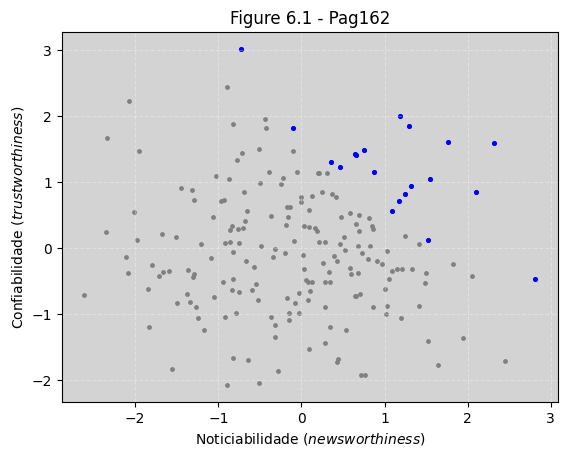

In [4]:
plt.scatter(tw, nw, s=6, color='gray')
plt.scatter(tw[selected], nw[selected], s=7, color='blue')

plt.title('Figure 6.1 - Pag162')
plt.xlabel('Noticiabilidade ($newsworthiness$)')
plt.ylabel('Confiabilidade ($trustworthiness$)')

plt.grid(ls='--', color='white', alpha=0.3)

### RCode 6.2 - pag163


In [5]:
N = 100

np.random.seed(909)  # Teste com outras sementes

height = np.random.normal(10, 2,  N)

leg_proportion = np.random.uniform(0.4, 0.5, N)

leg_left  = np.random.left = leg_proportion * height + np.random.normal(0, 0.02, N)
leg_right = np.random.left = leg_proportion * height + np.random.normal(0, 0.02, N)


df = pd.DataFrame({'height': height, 
                   'leg_left': leg_left, 
                   'leg_right': leg_right})
df.head()

,height,leg_left,leg_right
0,8.463728,4.094675,4.078446
1,9.854070,4.776475,4.687749
2,8.668694,4.192607,4.256472
3,7.523768,3.088674,3.088206
4,9.381352,4.093217,4.048181


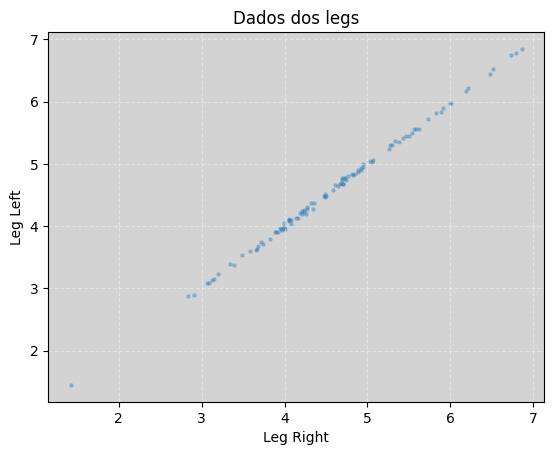

In [6]:
plt.scatter(leg_right, leg_left, s=5, alpha=0.3)

plt.title('Dados dos legs')
plt.xlabel('Leg Right')
plt.ylabel('Leg Left')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

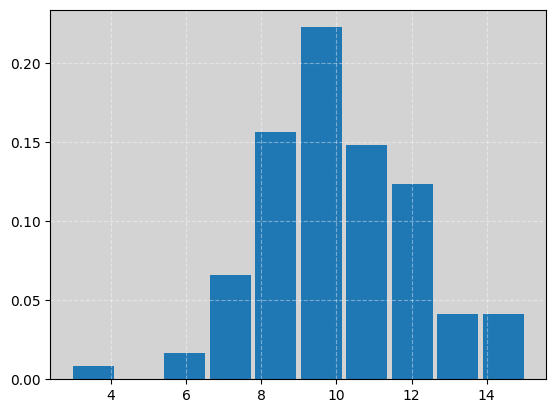

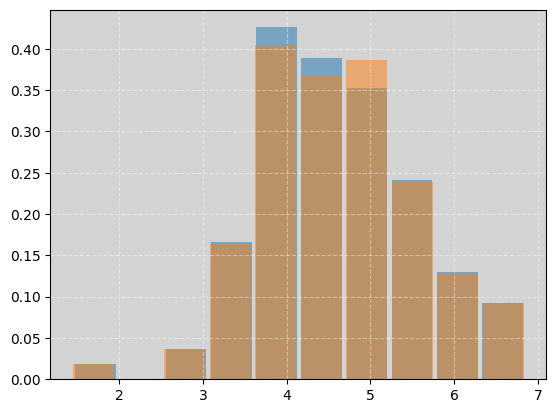

In [7]:
plt.hist(df.height, rwidth=0.9, density=True)
plt.grid(ls='--', color='white', alpha=0.4)
plt.show()

plt.hist(df.leg_left, rwidth=0.9, density=True, alpha=0.5)
plt.hist(df.leg_right, rwidth=0.9, density=True, alpha=0.5)

plt.grid(ls='--', color='white', alpha=0.4)
plt.show()

In [8]:
model = """
    data {
        int<lower=0> N;
        vector[N] height;
        vector[N] leg_left;
        vector[N] leg_right;
    }
    
    parameters {
        real alpha;
        real beta_left;
        real beta_right;
        real<lower=0> sigma; 
    }
    
    model {
        alpha ~ normal(10, 100);
        beta_left ~ normal(2, 10);
        beta_right ~ normal(2, 10);
        sigma ~ exponential(1);
        
        height ~ normal(alpha + beta_left * leg_left + beta_right * leg_right, sigma);
    }
"""

data = {
    'N': N,
    'height': height,
    'leg_left': leg_left,
    'leg_right': leg_right
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

alpha = samples['alpha'].flatten()
beta_left = samples['beta_left'].flatten()
beta_right = samples['beta_right'].flatten()
sigma = samples['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ck8txll7/model_gsymk2uq.stan', line 17, column 27: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  65% (5200/8000)
Sampling:  79% (6300/800

In [9]:
def HPDI(posterior_samples, credible_mass):
    
    # Calcula o maior intervalo de probabilidades a partir de uma amostra
    
    # Fonte: https://stackoverflow.com/questions/22284502/highest-posterior-density-region-and-central-credible-region
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
        HDImin = sorted_points[ciWidth.index(min(ciWidth))]
        HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]

    return(HDImin, HDImax)

In [10]:
def resume_posteriori(posteriori, var, confidence_HPDI=0.93, rounded=2):
    """
    Return the summary of posteriori data
    """
    posteriori = []

    confi_HPDI = HPDI(var, confidence_HPDI)
    
    posteriori.append(var.mean())
    posteriori.append(var.std())
    posteriori.append(confi_HPDI[0])
    posteriori.append(confi_HPDI[1])

    return np.round(np.array([posteriori]), rounded)[0]

In [11]:
def describe_posteriori(posteriori, vars_post, confidence_HPDI=0.93, plot=True):
    
    post = []
    
    for var_ in vars_post:
        post.append(resume_posteriori(posteriori, eval(var_), confidence_HPDI))
    
    hpdi_min_label = str(100 * round(1 - confidence_HPDI, 3)) + '%'
    hpdi_max_label = str(100 * round(confidence_HPDI, 3)) + '%'
        
    post = pd.DataFrame(post,
                        index=vars_post,
                        columns=['Mean', 'Std', hpdi_min_label, hpdi_max_label])
    
    if plot:
        
        plt.figure(figsize=(17, len(post) + 1))
    
        plt.title('Estimativas das Posterioris')
        
        min_axis_ = post.iloc[:, 2:4].min().min()
        max_axis_ = post.iloc[:, 2:4].max().max()

        for i in range(len(post)):
            plt.plot([min_axis_*1.5, max_axis_*1.5], [i, i], ls='--', color='gray')
            plt.plot([post.iloc[i, 2], post.iloc[i, 3]], [i, i], color='blue')
            plt.plot(post.iloc[i, 0], i, 'ko')
            plt.annotate(post.index[i], (min_axis_*1.5, i+0.2), color='blue')
            

        if min_axis_ < 0 and max_axis_ > 0:
            plt.axvline(0, ls='--', color='red', alpha=0.6)

        plt.ylim((-1, len(post)+1))
        plt.grid(ls='--', color='white', alpha=0.4)
        
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        
        plt.show()
    
    return post

### RCode 6.4 - pag164

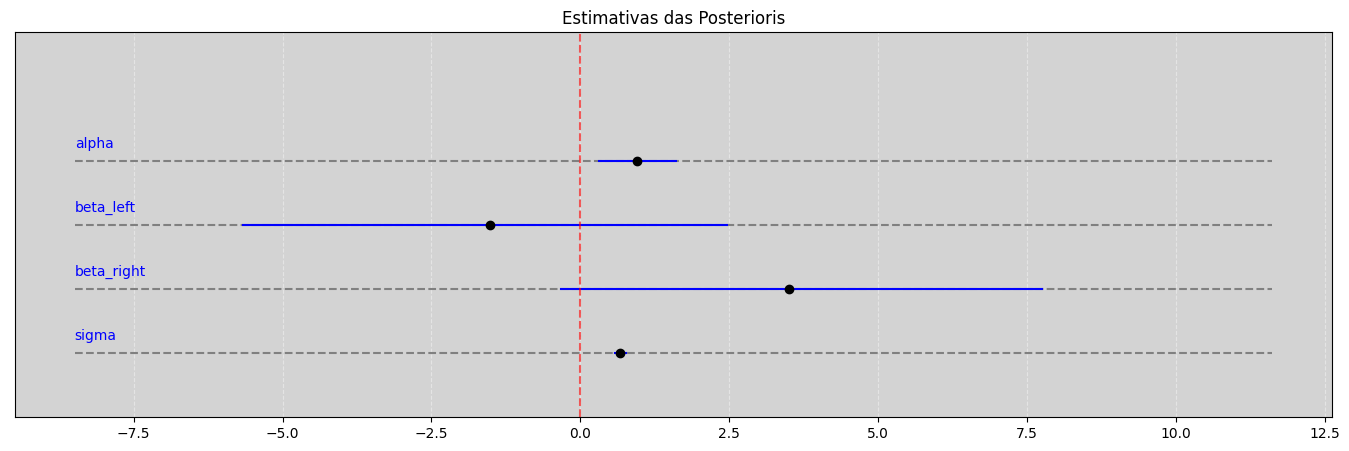

,Mean,Std,5.5%,94.5%
sigma,0.66,0.05,0.58,0.76
beta_right,3.51,2.08,-0.32,7.75
beta_left,-1.51,2.10,-5.66,2.47
alpha,0.95,0.34,0.31,1.61


In [12]:
vars_post = ['sigma', 'beta_right', 'beta_left', 'alpha']
describe_posteriori(posteriori, vars_post, 0.945, plot=True)

### RCode 6.5 - pag164

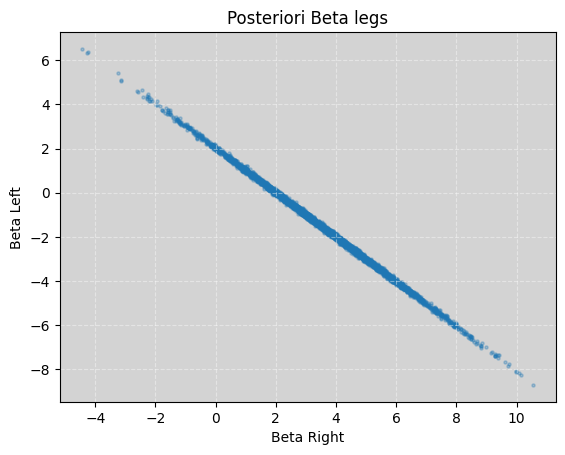

In [14]:
plt.scatter(beta_right, beta_left, s=5, alpha=0.3)

plt.title('Posteriori Beta legs')
plt.xlabel('Beta Right')
plt.ylabel('Beta Left')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

### RCode 6.6 - pag 165

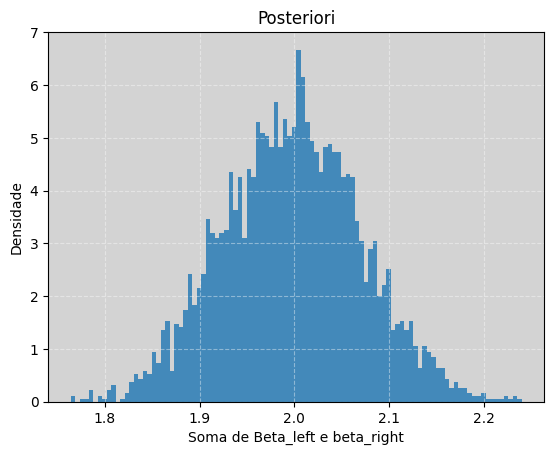

In [15]:
plt.hist((beta_left + beta_right), density=True, alpha=0.8, bins=100)

plt.title('Posteriori')
plt.xlabel('Soma de Beta_left e beta_right')
plt.ylabel('Densidade')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

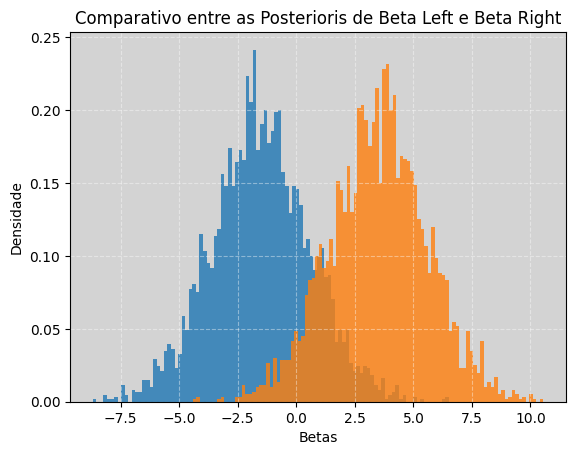

In [21]:
# Comparação com os beta indivíduais

plt.hist(beta_left, density=True, alpha=0.8, bins=100)  # Beta left

plt.hist(beta_right, density=True, alpha=0.8, bins=100)  # Beta Right

plt.title('Comparativo entre as Posterioris de Beta Left e Beta Right')
plt.xlabel('Betas')
plt.ylabel('Densidade')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

### RCode 6.7 - Pag 166

In [23]:
model = """
    data {
        int N;
        vector[N] leg_left;
        vector[N] height;
    }
    
    parameters {
        real alpha;
        real beta_left;
        real sigma;
    }
    
    model {
        alpha ~ normal(10, 100);
        beta_left ~ normal(2, 10);
        sigma ~ exponential(1);
        
        height ~ normal(alpha + beta_left * leg_left, sigma);
    }
"""

data = {
    'N': len(height),
    'leg_left': leg_left,
    'height': height,
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

alpha = samples['alpha'].flatten()
beta_left = samples['beta_left'].flatten()
sigma = samples['sigma'].flatten()

Building: 0.1s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:110,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/generalized_inverse.hpp: In function ‘Eigen::Matrix<typename stan::value_type<T>::type, EigMat::ColsAtCompileTime, EigMat::RowsAtCompileTime> stan

Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:321,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/tail.hpp: In function ‘std::vector<T1> stan::math::tail(const std::vector<T1>&, size_t)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/sit

Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:32,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp: In lambda function:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp:83:11: warning: typedef ‘using Block_ = class Eigen::Block<Eigen::Matrix<double, -1, -1>, -1, -1, false>’ local

Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:74,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp: In function ‘auto stan::math::generalized_inverse(const VarMat&)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp:64:9: warning: typedef ‘using value_t = stan::value_type_t<T>’

Building: 10.9s
Building: 11.0s
Building: 11.1s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:121,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp: In function ‘auto stan::math::lub_constrain(const T&, const L&, const U&)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:485:9: warning: typedef ‘using plain_x_array = stan::plain_type_

Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/bernoulli_logit_glm_log.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/

Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/multi_normal_cholesky_log.hpp:6,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:196,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/ma

Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/ordered_logistic_log.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:248,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/pr

Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/indexing.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:329:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  329 |   using pair_type = std::pair<int, arena_vec>;
      |         ^

Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.7s


/home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp: In instantiation of ‘void model_he7o66lc_namespace::model_he7o66lc::transform_inits_impl(const stan::io::var_context&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_std_vector_t<T>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:401:68:   required from here
/home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:259:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  259 |       int pos__;
      |           ^~~~~


Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s


/home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp: In instantiation of ‘void model_he7o66lc_namespace::model_he7o66lc::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_std_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.5.0/models/he7o66lc/model_he7o66lc.cpp:363:7:   required from ‘void model_he7o66lc_namespace::model_he7o66lc::write_array(RNG&, Eigen::Matrix<double, 

Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err.hpp:4,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Project

Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building

Building: 30.3s, done.
Messages from stanc:
Warning in '/tmp/httpstan_gahyqwl3/model_he7o66lc.stan', line 19, column 54: A normal distribution is given parameter sigma as a scale parameter (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gahyqwl3/model_he7o66lc.stan', line 17, column 8: Parameter sigma is given a exponential distribution, which has strictly positive support, but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gahyqwl3/model_he7o66lc.stan', line 15, column 27: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19

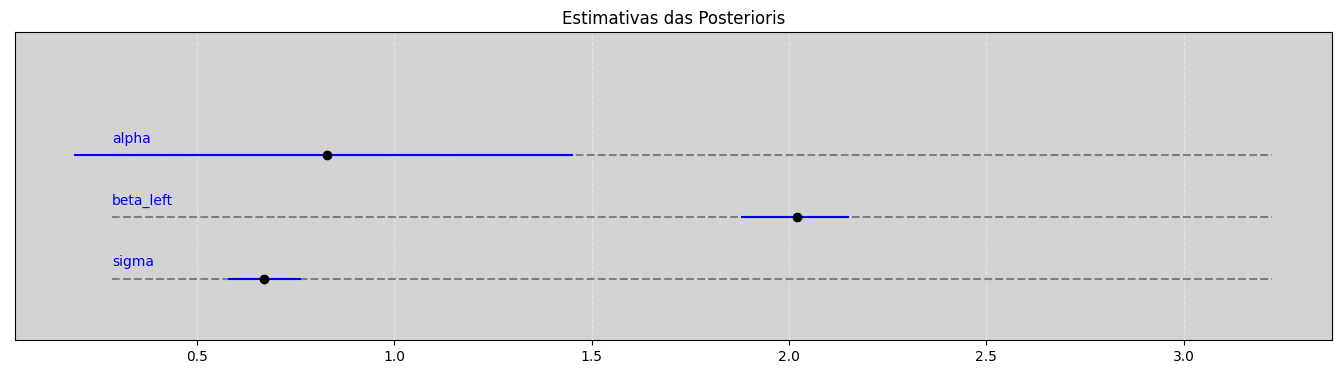

,Mean,Std,5.5%,94.5%
sigma,0.67,0.05,0.58,0.76
beta_left,2.02,0.07,1.88,2.15
alpha,0.83,0.33,0.19,1.45


In [24]:
# RCode 6.7 - Continuação
vars_post = ['sigma', 'beta_left', 'alpha']
describe_posteriori(posteriori, vars_post, 0.945, plot=True)